<a href="https://colab.research.google.com/github/srijayjk/Deep-Learning/blob/master/Classification_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep learning programming II: Classification
Felix Wiewel, Institute of Signal Processing and System Theory, University of Stuttgart, 24.04.2020

## Introduction
A common problem that arises in machine learning is the classifiaction of images. The goal of this exercise is to introduce you to the practical implementation of a complete pipeline for solving a classification task with neural networks in Tensorflow. For this we will make extended use of Keras, a specification of a high-level API for implementing powerful classes and functions to create and train neural networks. Tensorflow already comes with an implementation of the Keras specification so there is no need to install Keras if you have already installed Tensorflow. Usign Keras instead of low level tensorflow code to implement your neural networks and their training algorithms comes with some advantages but also some disadvantages. Since Keras makes it very easy to build and train neural networks, even people without strong programming skills can quickly develop solutions for given problems using neural networks. Keras essantially provides an abstract interface to the user and takes care of the low-level implementation details. This, however, comes with a cost. Since many technical details are hidden from the user, it is sometimes quite difficult to modify and change certain parts of your model/training algorithm. To a certain extend Keras provides you with ways to implement custom network architectures, custom layers and custom training algorithms but sometimes having to write code that is compliant with the Keras specification is more difficult than implementing it in low-level Tensorflow code. But for most standard applications, e.g. simple image classification like in this exercise, Keras is flexible enough and can save you a lot of time and frustation.

## GPU support
In order to speed up calculations with Tensorflow, we need to change the runtime type of this notebook to GPU. For this click on "Runtime" in the top left menu and select "Change runtime type". Then choose "GPU" in the drop down list under "Hardware accelerator". This will enable tensorflow to execute calculations on a GPU provided by Google Colab.

## Mathematical Background
In classification we are interested in learning a function that maps an input $\mathbf{x}\in\mathbb{R}^{M}$ to one out of possibly many classes. In order to characterize such a mapping, we need a mathematical expression to uniquely identify different classes. This is typically done by assigning each class an integer value. So in the case of classifying images in the three classes Dog, Cat, Bird one could assign these classes with the one-hot vectors $\left[1,0,0\right]^{T},\left[0,1,0\right]^{T},\left[0,0,1\right]^{T}$. Using one-hot vectors to represent labels of indivudual classes is very useful for training neural networks. It closely matches the mathematical model that we will be using for interpreting the networks output where each of its elements describes a probability. In classification using neural networks we are interested in learning the function

$\mathbf{y}=f_{\boldsymbol{\theta}}(\mathbf{x})$,

where $f$ is a neural network with parameters $\boldsymbol{\theta}$ that maps our possibly high-dimensional input $\mathbf{x}\in\mathbb{R}^{M}$ to an output $\mathbf{y}\in\lbrace0,1\rbrace^{k}$ that represents one out of $k$ possible classes. Similar to the regression exercise, we will use a probabilistic view on this problem in order to derive a suitable cost function we can use to train our model. This time however, we will not introduce uncertainty through assuming some sort of noise acting on the prediction of the model as we did in the previous exercise. Instead we will treat both $\mathbf{x}$ and $\mathbf{y}$ as random variables with probability distribution functions (pdfs) $p(\mathbf{x})$ and $p(\mathbf{y})$. We already know that $\mathbf{y}$ can be one  out of $k$ classes, i.e. $p(\mathbf{y})$ is a cateorical distribution. Instead of trying to learn a deterministic function that maps an input $\mathbf{x}$ to an output $\mathbf{y}$ we can instead learn a function that takes $\mathbf{x}$ as an input and outputs a pdf over our $k$ different classes, i.e. $p(\mathbf{y}\vert\mathbf{x})$. In order to then classify an input we typically assign it with the class label that is most likely. In this way we can easily interprete the output of the model and also incorporate prior information into our decision. Using this probabilistic perspective on the classification problem we are interested in learning the conditional distribution

$p(\mathbf{y}\vert\mathbf{x})=\prod_{n=1}^{k}\mu_{n}(\mathbf{x})^{y_{n}}$,

where $y_{n}\in\lbrace0,1\rbrace$,  $\sum_{n=1}^{k}y_{n}=1$, $0\leq\mu_{n}(\mathbf{x})\leq1$ and $\sum_{n=1}^{k}\mu_{n}(\mathbf{x})=1$. In other words, we want to learn the parameters of a neural network $\boldsymbol{\theta}$ that, given an input $\mathbf{x}$, outputs $\mu_{n}(\mathbf{x})$ for $1\leq n\leq k$ satisfying the constraints $0\leq\mu_{n}(\mathbf{x})\leq1$ and $\sum_{n=1}^{k}\mu_{n}(\mathbf{x})=1$. Practically, we can realize this by designing a neural network that accepts $\mathbf{x}$ as an input and has an output layer with $k$ neurons and a softmax activation function. In order to derive a cost function for learning the parameters $\boldsymbol{\theta}$ of the neural network, we will again use the log likelihood

$\mathcal{L}(\mathbf{x},\mathbf{y},\boldsymbol{\theta})=\ln{p(\mathbf{y}\vert\mathbf{x},\boldsymbol{\theta})}=\ln{\prod_{n=1}^{k}\mu_{n}(\mathbf{x})^{y_{n}}}=\sum_{n=1}^{k}y_{n}\ln{\mu_{n}(\mathbf{x})}$,

where $\mu_{n}(\mathbf{x})$ depends on the parameters $\boldsymbol{\theta}$ of the neural network. The log likelihood measures how likely $\mathbf{y}$ is given $\mathbf{x}$ and the parameters $\boldsymbol{\theta}$. Maximizing the expected log likelihood over the complete data set yields the optimal parameters

$\boldsymbol{\theta}^{\star}=\arg\max_{\boldsymbol{\theta}}\mathbb{E}\left[\mathcal{L}(\mathbf{x},\mathbf{y},\boldsymbol{\theta})\right]=\arg\min_{\boldsymbol{\theta}}-\mathbb{E}\left[\sum_{n=1}^{k}y_{n}\ln{\mu_{n}(\mathbf{x})}\right]\approx\arg\min_{\boldsymbol{\theta}}-\dfrac{1}{N}\sum_{i=1}^{N}\sum_{n=1}^{k}y_{n,i}\ln{\mu_{n}(\mathbf{x}_{i})}$,

where we have reformulated the maximization as a minimization of the negative objective function and approximated the expectation with a sum. As you probably already noticed, the last term is the cross entropy loss that you are familiar with from the lecture. We can now again use SGD or some variant of it in order to minimize the cost function and obtain find some good parameters for our neural network. But keep in mind that while $\boldsymbol{\theta}^{\star}$ are the globally optimal parameters, we are usually only able to find locally optimal parameters due to the non-convex cost function that we are minimizing.

## Data set
In this exercise we will use common data sets like the MNIST or FashionMNIST data sets. Those and some other data sets are provided through simple functions in the Keras implementation of Tensorflow. For an overview of available data sets and how to use them click [here](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/datasets). The MNIST data set is a simple and very popular data set for handwritten digit classification. It contains $70000$ images with $28\times 28$ pixels that are split into $60000$ training and $10000$ test samples. Since the task is to classify a handwritten digit, the labels $y$ for each image are from the set $\lbrace0,\ldots,9\rbrace$. The FashionMNIST data set is very similar to MNIST it also has approximately the same number of images with exactly the same dimensions as MNIST. It was provided by Zalando research and contains $10$ classes of different fashion objects.

## Implementation
We can simply import all required packages and load some data set using Keras.

In [2]:
import tensorflow as tf
import tensorflow.keras as k
import numpy as np
import matplotlib.pyplot as plt

# Define constants
batch_size = 128
epochs = 20
learning_rate = 0.001

(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = tf.keras.datasets.mnist.load_data()
x_train_mnist = np.expand_dims(x_train_mnist, axis=-1).astype(np.float32)
x_test_mnist = np.expand_dims(x_test_mnist, axis=-1).astype(np.float32)

11493376/11490434 [==============================] - 1s 0us/step


We can also plot some examples in order to get an impresion of what the data looks like.

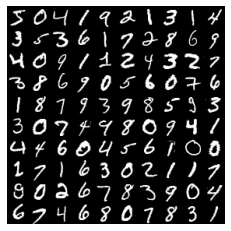

In [ ]:
plt_img = np.zeros((280, 280))
for i in range(10):
  for j in range(10):
    plt_img[i*28:(i+1)*28, j*28:(j+1)*28] = np.squeeze(x_train_mnist[i*10+j])
plt.imshow(plt_img, cmap="gray")
plt.axis("off")
plt.show()

Similar to the previous exercises we again derive a class for our model from the Keras Model class.

In [ ]:
""" Define a small convolutional network for classification with two conv. and 3 dense layers. The conv. layers should have 8/16 filters a kernel size of 3x3 and a stride of 2. The dense layers should have 128/64/? 
neurons. Choose the activation functions of the layers accordingly."""

class MyModel(k.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        # Layer definition
        self.conv0 = k.layers.Conv2D(8, (3,3), strides=2, activation='relu', input_shape = (28, 28, 1))
        self.conv1 = k.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=2, activation='relu')
        self.flatten = k.layers.Flatten()
        self.dense0 = k.layers.Dense(128, activation='relu')
        self.dense1 = k.layers.Dense(64, activation='relu')
        self.dense2 = k.layers.Dense(10, activation='softmax')

    def call(self, inputs, training=False):
        # Call layers appropriately to implement a forward pass
        output = self.conv0(inputs)
        output = self.conv1(output)
        output = self.flatten(output)
        output = self.dense0(output)
        output = self.dense1(output)
        output = self.dense2(output)
        return output

We can now instanciate an object of this class and compile it using the the cross-entropy loss function.

In [ ]:
""" Instantiate an object of MyModel and an RMSprop optimizer with learning rate given by the constant "learning_rate". Compile the model with a suitable loss function and add accuracy as a metric. """

mdl = MyModel()
opt = tf.optimizers.RMSprop(learning_rate)
mdl.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics= ['accuracy'])

Now we are ready to train the model and log the metrics for plotting.

In [ ]:
""" Train the model mdl on the training data with a batch size of "batch_size" for "epochs" epochs. Train with 10% of the training data as validation data. """

history_no_dropout = mdl.fit(x_train_mnist, y_train_mnist, batch_size, epochs, validation_data=(x_test_mnist, y_test_mnist))


Epoch 1/20
469/469 [==============================] - 2s 4ms/step - loss: 0.5571 - accuracy: 0.8883 - val_loss: 0.1385 - val_accuracy: 0.9586
Epoch 2/20
469/469 [==============================] - 2s 3ms/step - loss: 0.1052 - accuracy: 0.9689 - val_loss: 0.1127 - val_accuracy: 0.9660
Epoch 3/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0653 - accuracy: 0.9802 - val_loss: 0.0740 - val_accuracy: 0.9787
Epoch 4/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0450 - accuracy: 0.9858 - val_loss: 0.0860 - val_accuracy: 0.9746
Epoch 5/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0332 - accuracy: 0.9898 - val_loss: 0.0797 - val_accuracy: 0.9806
Epoch 6/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0285 - accuracy: 0.9915 - val_loss: 0.0811 - val_accuracy: 0.9788
Epoch 7/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0224 - accuracy: 0.9929 - val_loss: 0.0812 - val_accuracy: 0.9824
Epoch 

Visualizing the training process in a plot is possible by using the history object that contains a history dictionary. This is returned from the fit function and contains all the metrics logged over the training proces.

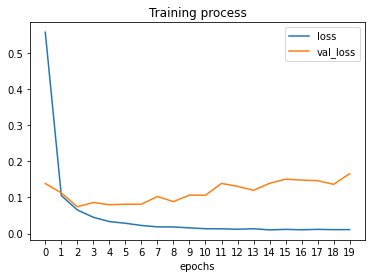

In [ ]:
plt.plot(history_no_dropout.history["loss"])
plt.plot(history_no_dropout.history["val_loss"])
plt.legend(["loss", "val_loss"])
plt.xticks(range(epochs))
plt.xlabel("epochs")
plt.title("Training process")
plt.show()

As you can see, the model is clearly overfitting. The loss on the training data is decreasing further and further with every epoch, while the loss on the validation data rises at the same time. We can avoid this by using dropout, which is a strong regularization that you should be familiar with from the lecture. For this we define a new model that has an additional dropout layer with a drop probability of $0.25$ before the first fully connected layer. Otherwise this model is the same as the model above.

In [ ]:
""" Create a new model, which is identical to MyModel execpt for a dropout layer between the conv. and dense layers. As a dropout rate use 0.25 """

class MyDropoutModel(k.Model):
    def __init__(self):
        super(MyDropoutModel, self).__init__()
        # Layer definition
        self.conv0 = k.layers.Conv2D(8, (3, 3), strides=2, activation='relu', input_shape = (28, 28, 1))
        self.conv1 = k.layers.Conv2D(16, (3, 3), strides=2, activation='relu')
        self.flatten = k.layers.Flatten()
        self.dropout = k.layers.Dropout(0.25)
        self.dense0 = k.layers.Dense(128, activation='relu')
        self.dense1 = k.layers.Dense(64, activation='relu')
        self.dense2 = k.layers.Dense(10, activation='softmax')

    def call(self, inputs, training=False):
        # Call layers appropriately in order to implement the forward pass
        output = self.conv0(inputs)
        output = self.conv1(output)
        output = self.flatten(output)
        output = self.dropout(output, training = training)
        output = self.dense0(output)
        output = self.dense1(output)
        output = self.dense2(output)
        return output

We can now create an instance of this model, train it and visualize the training process.

Epoch 1/20
469/469 [==============================] - 2s 4ms/step - loss: 0.6034 - accuracy: 0.8450 - val_loss: 0.1219 - val_accuracy: 0.9619
Epoch 2/20
469/469 [==============================] - 2s 4ms/step - loss: 0.1554 - accuracy: 0.9523 - val_loss: 0.0857 - val_accuracy: 0.9720
Epoch 3/20
469/469 [==============================] - 2s 3ms/step - loss: 0.1097 - accuracy: 0.9663 - val_loss: 0.0668 - val_accuracy: 0.9798
Epoch 4/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0872 - accuracy: 0.9722 - val_loss: 0.0634 - val_accuracy: 0.9810
Epoch 5/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0762 - accuracy: 0.9769 - val_loss: 0.0533 - val_accuracy: 0.9839
Epoch 6/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0666 - accuracy: 0.9793 - val_loss: 0.0579 - val_accuracy: 0.9827
Epoch 7/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0604 - accuracy: 0.9807 - val_loss: 0.0503 - val_accuracy: 0.9840
Epoch 

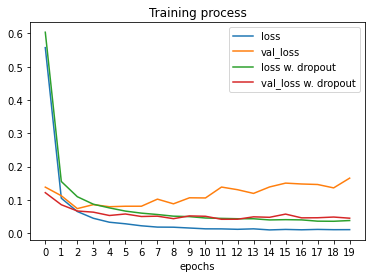

In [ ]:
""" Instantiate a MyDropoutModel object, compile and train it on the training data. Use the same optimizer and parameters for training as before. """

dropout_mdl = MyDropoutModel()
dropout_opt = tf.optimizers.RMSprop(learning_rate)
dropout_mdl.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics= ['accuracy'])

history_dropout = dropout_mdl.fit(x_train_mnist, y_train_mnist, batch_size=batch_size, epochs=epochs, validation_data=(x_test_mnist, y_test_mnist))

plt.plot(history_no_dropout.history["loss"])
plt.plot(history_no_dropout.history["val_loss"])
plt.plot(history_dropout.history["loss"])
plt.plot(history_dropout.history["val_loss"])
plt.legend(["loss", "val_loss", "loss w. dropout", "val_loss w. dropout"])
plt.xticks(range(epochs))
plt.xlabel("epochs")
plt.title("Training process")
plt.show()

While the model without dropout can reach a much lower loss on the training data, it generalizes very poorly to the unseen validation data. The model with dropout however generalizes quite good to the validation data and achieves a similar loss on both the data used during training and unseen data. This demonstrates that using dropout can be a good way to regularize your networks and prevent overfitting. Although dropout helps to prevent overfitting very well, it introduces another hyperparameter, the drop probability, that needs to be optimized. Common values for this hyperparameter are on the interval $\left[0.2,0.5\right]$.

## Transfer Learning
In many applications there is only a limited amount of annotated data available. In order to still train a neural network that generalizes well on such a data set, one can use transfer learning. In transfer learning the goal is to transfer knowledge from a source domain or task to a target domain or task. The hope is that this transfer will be positive, i.e. the performance on the target domain or task increases compared to only training on the target data set. A requirement for succesfull transfer learning is that the source and target have something in common, e.g. similar features. There is a broad literature on transfer learning methods but in this exercise we will restrict ourselves to the most basic approach, fine tuning. Fine tuning can be implemented by using a part of a neural network, which was trained on the source domain or task, as a feature extractor. A common approach is to use neral network pretrained on the ImageNet data set as a feature extractor. In this exercise, we will also use a neural network pretrained on ImageNet in order to fine tune it for the [Caltech 101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) data set. For a guide on transfer learning using fine tuning with Keras click [here](https://www.tensorflow.org/beta/tutorials/images/transfer_learning).

In order to do this we first need to download an extract the data set. Note that there is a wide collection of data sets available through the [tensorflow_datasets](https://www.tensorflow.org/datasets) package including Caltech101. But for demonstration purposses we manually download and load the images using Keras.

In [ ]:
!wget -N http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
!tar -xzf 101_ObjectCategories.tar.gz

--2020-06-24 14:52:34--  http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
Resolving www.vision.caltech.edu (www.vision.caltech.edu)... 34.208.54.77
Connecting to www.vision.caltech.edu (www.vision.caltech.edu)|34.208.54.77|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131740031 (126M) [application/x-tar]
Saving to: ‘101_ObjectCategories.tar.gz’

101_ObjectCategorie 100%[===================>] 125.64M  5.44MB/s    in 28s     

2020-06-24 14:53:03 (4.44 MB/s) - ‘101_ObjectCategories.tar.gz’ saved [131740031/131740031]



In order to feed our model with the data, we will use the ImageDataGenerator class provided by Keras. This class can be used for reading files from a structured directory, create the labels based on the structure of the directory and apply data augmentation techniques. The ImageDataGenerator already supports a lot of techniques for data augmentation. In our example, we use a random rotation, width shift, height shift, shearing, zomming and horizontal flipping. All of those operations are applied randomly to individual images. More information on the available transformations for data augmentation and how to use them see the [documentation](https://www.tensorflow.org/versions/r2.2/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#__init__).

In [ ]:
N_samples_Caltech101 = 9144
val_split = 0.1
datagen = k.preprocessing.image.ImageDataGenerator(validation_split=val_split,
                                                   preprocessing_function=k.applications.mobilenet_v2.preprocess_input,
                                                   rotation_range=20,
                                                   width_shift_range=0.1,
                                                   height_shift_range=0.1,
                                                   shear_range=0.1,
                                                   zoom_range=0.1,
                                                   horizontal_flip=True)

Now that we have the data set we can load the pretrained model. Keras provides a range of pretrained models called "applications", click [here](https://www.tensorflow.org/api_docs/python/tf/keras/applications) for a link to its documentation. We will use the MobileNetV2 architecture without it's output layer, since we want to modify it in order to apply the model to the Caltech 101 data set.

In [ ]:
""" Instantiate a MobileNetV2 with weights pretrained on ImageNet and without the top/output layer. Hint: Use Keras Applications"""

base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet')
base_model.summary()

9412608/9406464 [==============================] - 1s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
________________

With the pretrained model we can build our actual model that adds an output layer to the MobileNetV2.

In [ ]:
""" Create a transfer learning model, that uses a pretrained model "pretrained_model" and appends a 2D global average pooling layer, a dropout layer (droprate 0.25) and a dense output layer with 102 neurons. """

class MyTransferModel(k.Model):
    def __init__(self, pretrained_model):
        super(MyTransferModel, self).__init__()
        # Define layers and pretrained model
        self.basemodel = pretrained_model
        self.pool = k.layers.GlobalAveragePooling2D()
        self.dropout = k.layers.Dropout(0.25)
        self.dense = k.layers.Dense(102, activation='softmax')

    def call(self, inputs, training=False):
        # Call pretrained model and layers appropriately to implement forward pass
        output = self.basemodel(inputs)
        output = self.pool(output)
        output = self.dropout(output, training = training)
        output = self.dense(output)
        return output

Now we just need to instantiate our model for transfer learning and fine tune it. But instead of directly training all layers we will just train the last layer first. If you do not do this and directly train the complete model, the random initialization of the last layer can cause gradients with very big magnitude that will be propageted into the MobileNetV2 layers and cause them to "forget" what they have learned on ImageNet. This is undesireable since we want to transfer that knowledge over into our model in order to achieve better performance on the Caltech 101 data set.

In [ ]:
""" Instantiate a MyTransferModel object and a RMSprop optimizer, compile them with a suitable loss and accuracy as a metric. Use "base_model" as the pretrained model. """

tf_batch_size = 32
tf_epochs = 10
tf_learning_rate = 0.001
tf_mdl = MyTransferModel(pretrained_model= base_model)
tf_opt = tf.optimizers.RMSprop(learning_rate)
base_model.trainable = False
tf_mdl.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics= ['accuracy'])
tf_mdl.build((tf_batch_size, 224, 224, 3))
tf_mdl.summary()

""" Create the data set generators and train the model for "tf_epochs" epochs. Hint: Use the class mode "sparse" and the appropriate subsets for creating the generators and 
steps_per_epoch=int((1.0-val_split)*N_samples_Caltech101/tf_batch_size) as well as a suitable number of validation_steps for the fit function. The data for the Caltech101 
data set is located in the "101_ObjectCategories" directory. """

train_gen = datagen.flow_from_directory(directory='101_ObjectCategories', class_mode='sparse', subset='training')
val_gen = datagen.flow_from_directory(directory='101_ObjectCategories', class_mode='sparse', subset='validation')
tf_history_0 = tf_mdl.fit(x=train_gen, y=None, epochs= tf_epochs, validation_steps= val_split , steps_per_epoch=int((1.0-val_split)*N_samples_Caltech101/tf_batch_size), validation_data=val_gen)

Model: "my_transfer_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, None, None, 1280)  2257984   
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_6 (Dense)              multiple                  130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________
Found 8278 images belonging to 102 classes.
Found 866 images belonging to 102 classes.
Epoch 1/10
257/257 [==============================] - 118s 458ms/step - loss: 1.4091 - accuracy: 0.6922 - val_loss: 1.0105 - val_accuracy: 0.687

Now that we have trained the outputlayer of our model on the Caltech 101 data set, we can make the last layers of the MobileNetV2 model trainable and continue to fine tune  it with a low learning rate. For this we need to recompile our model in order for the change of the MobileNetV2 parameters to trainable to have an effect.

In [ ]:
""" Reinstantiate the RMSprop optimizer with the changed learning rate and set the base_model to be trainable. Then compile it with the newly instantiate optimizer, a suitable loss function and accuracy as a metric 
and continue training on the Caltech101 data set. Hint: Angain use steps_per_epoch=int((1.0-val_split)*N_samples_Caltech101/tf_batch_size) as well as a suitable number of validation_steps to train the model fo
"tf_epochs" epochs on the data set. """

tf_learning_rate = 0.00001
tf_opt = tf.optimizers.RMSprop(tf_learning_rate)
# Set base_model to be trainable
tf_mdl.compile(loss="sparse_categorical_crossentropy", optimizer=tf_opt, metrics=["accuracy"])
tf_mdl.build((tf_batch_size, 224, 224, 3))
tf_mdl.summary()

tf_history_1 = tf_mdl.fit(x=train_gen, y=None, epochs=tf_epochs, validation_steps=val_split, steps_per_epoch=int((1.0-val_split)*N_samples_Caltech101/tf_batch_size), validation_data=(val_gen))

Model: "my_transfer_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, None, None, 1280)  2257984   
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_6 (Dense)              multiple                  130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/10
257/257 [==============================] - 118s 458ms/step - loss: 0.1190 - accuracy: 0.9649 - val_loss: 0.1095 - val_accuracy: 0.9375
Epoch 2/10
257/257 [==============================] - 117s 456ms/step - loss: 0.1024 

As you can see from the increasing gap between training and validation loss and accuracy, overfitting is becoming a bigger problem now. This is due to the much higher number of trainable parameters if we not only train the output layer on the rather small Caltech 101 data set. But still we can improve the performance of our model. We can visualize this if we plot the accuracy over the training process.

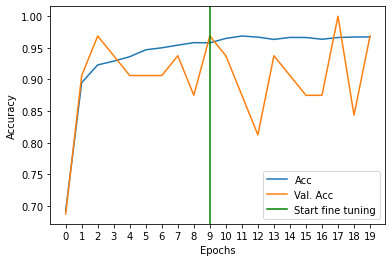

In [ ]:
plt.plot(tf_history_0.history["accuracy"]+tf_history_1.history["accuracy"])
plt.plot(tf_history_0.history["val_accuracy"]+tf_history_1.history["val_accuracy"])
plt.xticks(range(len(tf_history_0.history["accuracy"]+tf_history_1.history["accuracy"])))
plt.axvline(9, color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Acc", "Val. Acc", "Start fine tuning"])
plt.show()

Overall the resulting performance of the model is quite close to published results on the Caltach 101, e.g. this [paper](https://arxiv.org/abs/1406.4729v1), while the definintion and training of the model only required very little code.

In order to evaluate if transfer learning actually makes a difference, we can simply train the MobileNetV2 on the Caltech 101 data set. As we already discussed, training such a high capacity model on such a small data set leads to heavy overfitting.

In [ ]:
""" Instantiate a new base_model, now with randomly initialized weights, and instantiate a new MyTransferModel object. Compile it with a RMSprop optimizer, a suitable loss and accuracy as a metric.  """

tf_batch_size = 32
tf_epochs = 5
tf_learning_rate = 0.001
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet') #Instantiate a randomly initialized MobileNetV2 without it's top/output layer
tf_mdl = MyTransferModel(pretrained_model= base_model)
tf_opt = tf.optimizers.RMSprop(learning_rate)
tf_mdl.compile(loss="sparse_categorical_crossentropy", optimizer=tf_opt, metrics=["accuracy"])
tf_mdl.build((tf_batch_size, 224, 224, 3))
tf_mdl.summary()

""" Train this newly instantiated model on the Caltech101 data set. Hint: Again use steps_per_epoch=int((1.0-val_split)*N_samples_Caltech101/tf_batch_size) as well as a suitable number of validation_steps. """

tf_history_2 = tf_mdl.fit(x=train_gen, y=None, epochs=tf_epochs, validation_steps=val_split, steps_per_epoch=int((1.0-val_split)*N_samples_Caltech101/tf_batch_size), validation_data=(val_gen))

Model: "my_transfer_model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, None, None, 1280)  2257984   
_________________________________________________________________
global_average_pooling2d_2 ( multiple                  0         
_________________________________________________________________
dropout_3 (Dropout)          multiple                  0         
_________________________________________________________________
dense_8 (Dense)              multiple                  130662    
Total params: 2,388,646
Trainable params: 2,354,534
Non-trainable params: 34,112
_________________________________________________________________
Epoch 1/5
257/257 [==============================] - 151s 588ms/step - loss: 1.4768 - accuracy: 0.6360 - val_loss: 20.5359 - val_accuracy: 0.0312
Epoch 2/5
257/257 [==============================] - 150s 582ms/step - loss: 0.7692 

As you can see, training MobileNetV2 from scratch does not only suffer from severe overfitting but is also rather slow when compared with fine tuning. So overall it is recommended to use pretrained models and transfer learning if you want to train a high capacity neural network on a small data set, as it is often the case in practical applications. By doing this you can benefit from not only the architecture search of many experts but also save time and computational resources since a part of your model has already be pretrained by someone else. But you should always keep in mind that transfer learning is only a suitable method if there is a realistic chance of a positive transfer, i.e. the data set and task the model was pretrained on has to have something in common with your data set and task. Otherwise transfer learning can not only slow down the convergence speed but also hurt the final performance of your model.

## Catastrophic Forgetting
Despite many advances in better architectures and training algorithms for training, neural networks still suffer from a long known phenomenon called "catastrophic forgetting". In order to understand what this phenomenon is we can compare human learning with the way neural networks learn. Humans can quickly learn from few examples and most importantly, they can learn to solve tasks in a sequential way. This means one can learn a language, e.g. english, and after a certain period of time learn a second language, e.g. chinese, without having to repeatedly refresh everthing that was learned on the first language. Neural networks are currently not capable of learning on a sequence of different tasks. In order to demonstrate this, we will train a neural network first on MNIST and then on the FashionMNIST data set. We want to be able to uniquely identify any class from both data sets. Since both data sets contain $10$ classes and use the labels $\lbrace0,\ldots,9\rbrace$ for them, we need to choose different labels for the FashionMNIST data set. We do this by loading the data set and shifting the labels by $10$ so that we get labels $\lbrace10,\ldots,19\rbrace$.

In [11]:
""" Shift the labels of the FashionMNIST data set to {10,...,19}. """

(x_train_fmnist, y_train_fmnist), (x_test_fmnist, y_test_fmnist) = tf.keras.datasets.fashion_mnist.load_data()

x_train_fmnist = np.expand_dims(x_train_fmnist, axis=-1).astype(np.float32)
y_train_fmnist = np.expand_dims(y_train_fmnist, axis=-1).astype(np.float32) # Shift labels of training data
x_test_fmnist = np.expand_dims(x_test_fmnist, axis=-1).astype(np.float32)
y_test_fmnist = np.expand_dims(y_test_fmnist, axis=-1).astype(np.float32) # Shift labels of testing data

We also plot some examples of this data set and varify if the labels were shifted correctly.

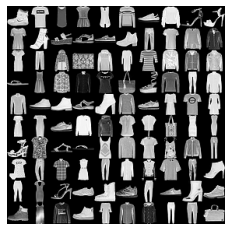

Labels
MNIST: [0 1 2 3 4 5 6 7 8 9]
FashionMNIST: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


In [12]:
plt_img = np.zeros((280, 280))
for i in range(10):
  for j in range(10):
    plt_img[i*28:(i+1)*28, j*28:(j+1)*28] = np.squeeze(x_train_fmnist[i*10+j])
plt.imshow(plt_img, cmap="gray")
plt.axis("off")
plt.show()

print("Labels")
print("MNIST: "+str(np.unique(y_test_mnist)))
print("FashionMNIST: "+str(np.unique(y_test_fmnist)))

Now the data is prepared we need to define a new model that can classify images into $20$ different classes. This is necessary since the models we used up to this point only have $10$ neurons in their output layers and therefore are only capable of classifying into $10$ different categories.

In [14]:
""" Implement a new model, which is capable of classifying 20 classes. Use two conv. layers with 8/16 filters of size 3x3 and a stride of 2, a dropout layer between the conv. and dense layers with a droprate of 0.25 
three dense layers with 128/64/? neurons. Choose all activation functions appropriately."""

class MyExtendedModel(k.Model):
    def __init__(self):
        super(MyExtendedModel, self).__init__()
        # Layer definition
        self.conv0 = k.layers.Conv2D(8, (3, 3), strides=3, activation='relu')
        self.conv1 = k.layers.Conv2D(16, (3, 3), strides=2, activation='relu')
        self.flatten = k.layers.Flatten()
        self.dropout = k.layers.Dropout(0.25)
        self.dense0 = k.layers.Dense(128, activation='relu')
        self.dense1 = k.layers.Dense(64, activation='relu')
        self.dense2 = k.layers.Dense(20, activation='softmax')

    def call(self, inputs, training=False):
        # Call layers in correct order to implement forward pass
        output = self.conv0(inputs)
        output = self.conv1(output)
        output = self.flatten(output)
        output = self.dropout(output, training = training)
        output = self.dense0(output)
        output = self.dense1(output)
        output = self.dense2(output)
        return output

With this model we are almost redy to start training on a sequence of tasks, i.e. we will first train on the MNIST data set in order to learn the classes $0$ up to $9$ and after that train on the FshionMNIST data set in order to learn the remaining classes from $10$ to $19$. During this process we want to evaluate the model separately on MNIST and FashionMNIST validation data. Since this is not a standard procedure, we need to implement a Callback class. Callbacks in Keras are used to implement actions that are executed at different points during the training process, e.g. at the beginning of the training, after a batch is processed or at the end of each epoch. See the [documentation](https://www.tensorflow.org/versions/r2.2/api_docs/python/tf/keras/callbacks) for an overview of all provided callbacks and the [guide](https://www.tensorflow.org/beta/guide/keras/custom_callback#an_overview_of_callback_methods) on writing custom callbacks. While there are predefined callbacks, e.g. for logging metrics into a tensorboard log file, there is unfortunately no callback that we could use to evaluate our model simultaneously on two different validation data sets. The only option we have is to implement our own callback.

In [18]:
""" Implement a custom callback that evaluates a model on two data sets at the end of an epoch and stores the results in a two separate lists. Hint: The Keras callback class always posses an assotiated model. You can 
use it via the "self.model" attribute of the class. Hint: Evaluating the model will return a tuple containing two elements, i.e. (loss, acc).  """

class MyCallback(tf.keras.callbacks.Callback):
  # Get the two different data sets and create lists for storing results
  def __init__(self, x_0, y_0, x_1, y_1, batch_size):
    super(MyCallback, self).__init__()
    self.x_0 = x_0
    self.y_0 = y_0
    self.x_1 = x_1
    self.y_1 = y_1
    self.loss_0 = []
    self.acc_0 = []
    self.loss_1 = []
    self.acc_1 = []
    self.batch_size = batch_size
    
  def on_epoch_end(self, epoch, logs=None):
    # Evaluate the model on both data sets and store results
    print("\nStarting callback...")
    print("+----------------------+")
    print("| Data set 0           |")
    print("+----------------------+")
    metrics_0 = self.model.evaluate(self.x_0, self.y_0, batch_size = self.batch_size)   #Evaluate the model on "self.x_0" and "self.y_0" with "self.batch_size"
    self.loss_0.append(metrics_0[0])
    self.acc_0.append(metrics_0[1])
    # Append loss to the loss list "self.loss_0" and accuracy to the accuracy list "self.acc_0"
    print("+----------------------+")
    print("| Data set 1           |")
    print("+----------------------+")
    metrics_1 = self.model.evaluate(self.x_1, self.y_1, batch_size = self.batch_size)#Evaluate the model on "self.x_1" and "self.y_1" with "self.batch_size"
    self.loss_1.append(metrics_1[0])
    self.acc_1.append(metrics_1[1])
    # Append loss to the loss list "self.loss_1" and accuracy to the accuracy list "self.acc_1"
    print("Callback completed...")

This callback will accept two data sets on its initialization that can be used during training to evaluate on. For this we override the on_epoch_end function to evaluate on both data sets, print the results and store them for later use. We now train our neural network first on MNIST in order to learn the classes $\lbrace0,\ldots,9\rbrace$ and then on FashionMNIST in order to learn the classes $\lbrace10,\ldots,19\rbrace$  while simultaneously evaluating the model on both, the MNIST and FashionMNIST test sets. If our neural network would be capable of learning continually, we would expect to see the loss on MNIST decrease as we train on it and remain low as we continue with the training on FashionMNIST. Similarly we would expect the accuracy to rise on MNIST as we train on it and remain stable even if we continue to train on FashionMNIST.

In [19]:
""" Instantiate a MyExtendedModel object, a RMSprop optimizer with learning rate "learning_rate" and compile them with a suitable loss function and accuracy as a metric. Then instantiate a MyCallback object with the 
MNIST test data set "x_test_mnist", "y_test_mnist" and the FashionMNIST test data set "x_test_fmnist", "y_fmnist". Finally train the model first on the MNIST training data set and then on the FashionMNIST data set. 
Hint: Use the MyCallback object "my_cb" during the training in order to record the accuracies on both data sets during training. """

extended_mdl = MyExtendedModel()
extended_opt = tf.optimizers.RMSprop(learning_rate)
extended_mdl.compile(loss='sparse_categorical_crossentropy', optimizer=extended_opt, metrics=['accuracy'] )

my_cb = MyCallback(x_test_mnist, y_test_mnist, x_test_fmnist, y_test_fmnist, batch_size)

extended_mdl.fit(x_train_mnist, y_train_mnist, batch_size=batch_size, epochs=epochs, callbacks=[my_cb]) # Train on MNIST
extended_mdl.fit(x_train_fmnist, y_train_fmnist, batch_size=batch_size, epochs=epochs, callbacks=[my_cb]) # Train on FashionMNIST

Epoch 1/20
465/469 [============================>.] - ETA: 0s - loss: 0.8289 - accuracy: 0.7971
Starting callback...
+----------------------+
| Data set 0           |
+----------------------+
79/79 [==============================] - 0s 3ms/step - loss: 0.1751 - accuracy: 0.9467
+----------------------+
| Data set 1           |
+----------------------+
79/79 [==============================] - 0s 3ms/step - loss: 4.2237 - accuracy: 0.0493
Callback completed...
469/469 [==============================] - 3s 7ms/step - loss: 0.8247 - accuracy: 0.7980
Epoch 2/20
463/469 [============================>.] - ETA: 0s - loss: 0.2136 - accuracy: 0.9347
Starting callback...
+----------------------+
| Data set 0           |
+----------------------+
79/79 [==============================] - 0s 3ms/step - loss: 0.1033 - accuracy: 0.9662
+----------------------+
| Data set 1           |
+----------------------+
79/79 [==============================] - 0s 3ms/step - loss: 4.0656 - accuracy: 0.0585
Callbac

If we now plot the loss on the test sets during the sequential training process on MNIST and FashionMNIST, we can clearly see what catastrophic forgetting means.

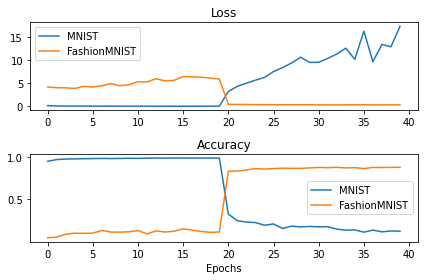

In [20]:
plt.subplot(2, 1, 1)
plt.plot(my_cb.loss_0)
plt.plot(my_cb.loss_1)
plt.legend(["MNIST", "FashionMNIST"])
plt.title("Loss")
plt.subplot(2, 1, 2)
plt.plot(my_cb.acc_0)
plt.plot(my_cb.acc_1)
plt.legend(["MNIST", "FashionMNIST"])
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.tight_layout()
plt.show()

We can clearly see the transition from training on MNIST to training on FashionMNITS on epoch $20$. At this epoch the loss on MNIST rapidly increases again while the loss on FashionMNIST rapidly decreases. For the accuracy we see a similar but opposite behaivior. It first is high while training on MNIST and then rapidly decreases towards $0$ as we transition to training on FashionMNIST. Avioding this phenomenon is an active area of research on deep learning and there already exist some methods in order to mitigate catastrophic forgetting. But so far solving continual learning with neural networks remains an interesting and challenging problem. If it can be solved, neural networks could learn more human like without a constant need to refresh previously learned examples and enable interesting new applications where knowledge is accumulated over time.

## Conclusion
In this exercise we have learned how to use Keras in order to quickly develop neural networks and train them on different data sets. We also refreshed the mathematical background on classification and explored how dropout can act as an effective regularization in order to mitigate overfitting. While the Keras specification offers a high-level of abstraction in order to simplify build and training neural networks, it also enables us to customize some parts of the complete workflow. In order to evaluate a model on two different data sets in order to visualize the phenomenon of catastrophic forgetting, we implemented a custom callback that executed our required action at the end of every epoch. Besides that Keras offers many other ways to implement non standard layers/methods. If you want to learn more on Keras, you can visit the documentation on the Keras implementation in Tensorflow [here](https://www.tensorflow.org/versions/r2.2/api_docs/python/tf/keras) or directly use the Keras specification available [here](https://keras.io). Additionally we explored a very basic transfer learning technique, i.e. fine tuning of pretrained models. For this we utilized the MobileNetV2 architecture that was trained on the ImageNet data set and fine tuned it on the Caltech 101 data set. The resulting model was simple to implement and fast to train, while it still achieved competetive results.